In [1]:
# ==========================================
# الخطوة 1: تجهيز المصنع واستلام المواد الخام
# ==========================================

import os
import shutil
from google.colab import files

# 1. تثبيت "عقل" النظام (مكتبة YOLO)
print("⚙️ جاري تثبيت أدوات الذكاء الاصطناعي...")
!pip install ultralytics -q
print("✅ تم التثبيت.")

# 2. تنظيف المكان (لضمان بداية نظيفة)
!rm -rf datasets archive.zip runs data.yaml

# 3. استلام الملف من المهندسة (أنتِ)
print("\n⬇️ يرجى رفع ملف 'archive.zip' الآن عند ظهور الزر...")
uploaded = files.upload()
filename = next(iter(uploaded))

# 4. فك الصناديق (Unzip)
print(f"\n📦 جاري فك ضغط {filename}...")
shutil.unpack_archive(filename, 'datasets')

# 5. الفحص البصري (أين الصور؟) 🕵️‍♂️
# هذا الجزء سيطبع لنا محتويات المجلد لنعرف "اسم المجلد" الصحيح
print("\n📂 محتويات المجلد بعد فك الضغط:")
for root, dirs, files in os.walk("datasets"):
    level = root.replace("datasets", "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    # نطبع أول ملفين فقط كعينة
    for f in files[:2]:
        print(f"{subindent}{f}")

⚙️ جاري تثبيت أدوات الذكاء الاصطناعي...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.9 MB/s eta 0:00:00
✅ تم التثبيت.

⬇️ يرجى رفع ملف 'archive.zip' الآن عند ظهور الزر...


Saving archive.zip to archive.zip

📦 جاري فك ضغط archive.zip...

📂 محتويات المجلد بعد فك الضغط:
datasets/
    NEU-DET/
        train/
            annotations/
                pitted_surface_156.xml
                inclusion_90.xml
            images/
                crazing/
                    crazing_24.jpg
                    crazing_231.jpg
                rolled-in_scale/
                    rolled-in_scale_200.jpg
                    rolled-in_scale_182.jpg
                pitted_surface/
                    pitted_surface_68.jpg
                    pitted_surface_226.jpg
                scratches/
                    scratches_128.jpg
                    scratches_131.jpg
                patches/
                    patches_127.jpg
                    patches_163.jpg
                inclusion/
                    inclusion_12.jpg
                    inclusion_41.jpg
        validation/
            annotations/
                rolled-in_scale_299.xml
                inclusion_286

In [2]:
import os
import glob
import yaml
from ultralytics import YOLO

print("🕵️‍♂️ جاري البحث عن الصور لتجهيز التدريب...")

# 1. البحث الذكي عن مسار الصور (Smart Path Finding)
# نبحث عن أي مجلد اسمه 'images' داخل مجلد 'train' أو العكس
possible_train_dirs = glob.glob('datasets/**/train/images', recursive=True) + \
                      glob.glob('datasets/**/images/train', recursive=True)

if possible_train_dirs:
    # وجدنا المسار!
    train_path = os.path.abspath(possible_train_dirs[0])
    print(f"✅ وجدنا صور التدريب في: {train_path}")

    # محاولة تخمين مسار الاختبار (valid أو val)
    val_path = train_path.replace('train', 'valid')
    if not os.path.exists(val_path):
        val_path = train_path.replace('train', 'val')

    # حل احتياطي: إذا لم نجد مجلد اختبار، نستخدم مجلد التدريب نفسه (لغايات العرض)
    if not os.path.exists(val_path):
        print("⚠️ تنويه: لم نجد مجلد اختبار منفصل، سنستخدم صور التدريب للاختبار أيضاً.")
        val_path = train_path

    # 2. إنشاء ملف الإعدادات (data.yaml) 📝
    # هذا الملف هو "الخريطة" التي يقرأها YOLO
    data_config = {
        'path': os.path.dirname(os.path.dirname(train_path)), # المجلد الرئيسي
        'train': train_path,
        'val': val_path,
        # أسماء العيوب الستة في بيانات NEU-DET
        'names': {0: 'crazing', 1: 'inclusion', 2: 'patches', 3: 'pitted_surface', 4: 'rolled-in_scale', 5: 'scratches'}
    }

    yaml_file = '/content/auto_config.yaml'
    with open(yaml_file, 'w') as f:
        yaml.dump(data_config, f)
    print("✅ تم إنشاء ملف الإعدادات بنجاح.")

    # 3. إطلاق التدريب (Ignition) 🚀
    print("\n🏭 جاري بدء تدريب الموديل (اصبري قليلاً، سيأخذ حوالي 5-10 دقائق)...")

    # نستخدم موديل Nano (الأسرع)
    model = YOLO('yolov8n.pt')

    # epochs=15: عدد الدورات (كافٍ جداً لمشروع تجريبي)
    results = model.train(data=yaml_file, epochs=15, imgsz=640)

    print("\n🎉 انتهى التدريب! الموديل جاهز.")

else:
    print("❌ خطأ: لم نجد أي مجلد صور! هل رفعتِ ملف 'archive.zip' الصحيح؟")
    # طباعة المجلدات للمساعدة
    print("محتويات المجلد الحالي:")
    print(os.listdir('datasets'))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🕵️‍♂️ جاري البحث عن الصور لتجهيز التدريب...
✅ وجدنا صور التدريب في: /content/datasets/NEU-DET/train/images
⚠️ تنويه: لم نجد مجلد اختبار منفصل، سنستخدم صور التدريب للاختبار أيضاً.
✅ تم إنشاء ملف الإعدادات بنجاح.

🏭 جاري بدء تدريب الموديل (اصبري قليلاً، سيأخذ حوالي 5-10 دقائق)...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/auto_config.yaml, degrees=0.0, deterministic=

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/15      2.49G          0      88.51          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.3it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 5.1it/s 8.9s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/15      2.51G          0      69.05          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 5.0it/s 9.0s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/15      2.53G          0      51.18          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 5.5it/s 8.2s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/15      2.54G          0      35.56          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.3it/s 20.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 7.0it/s 6.5s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/15      2.56G          0      24.35          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.1it/s 21.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.6it/s 6.9s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/15      2.58G          0      17.26          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.6it/s 6.9s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/15      2.59G          0      11.95          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.5it/s 6.9s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/15      2.61G          0      8.374          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.1it/s 7.4s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/15      2.63G          0       6.13          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.3it/s 7.1s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/15      2.64G          0       4.63          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.5it/s 7.0s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/15      2.66G          0      3.637          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.6it/s 6.8s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/15      2.68G          0      2.998          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.4it/s 7.0s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/15       2.7G          0      2.629          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.3it/s 7.1s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/15      2.71G          0      2.386          0          0        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 6.0it/s 7.5s
                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:832: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



15 epochs completed in 0.116 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 6.2MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 45/45 5.9it/s 7.6s


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:653: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:697: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/metrics.py:697: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/ultraly

                   all       1440          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/runs/detect/train

🎉 انتهى التدريب! الموديل جاهز.


In [5]:
import os
import shutil
import glob
import xml.etree.ElementTree as ET
import random
from ultralytics import YOLO
import cv2

print("🔄 تشغيل المطابق الذكي (Smart Matcher) لإصلاح البيانات...")

# 1. تنظيف وإعداد
if os.path.exists('converted_data'):
    shutil.rmtree('converted_data')

base_dir = 'converted_data'
os.makedirs(f'{base_dir}/train/images', exist_ok=True)
os.makedirs(f'{base_dir}/train/labels', exist_ok=True)
os.makedirs(f'{base_dir}/valid/images', exist_ok=True)
os.makedirs(f'{base_dir}/valid/labels', exist_ok=True)

# 2. البحث عن كل الملفات بغض النظر عن مكانها 🕵️‍♂️
print("🔍 جاري مسح كل الملفات...")
# نجمع كل الصور (bmp, jpg, png)
all_images_paths = glob.glob('datasets/**/*.jpg', recursive=True) + \
                   glob.glob('datasets/**/*.bmp', recursive=True) + \
                   glob.glob('datasets/**/*.png', recursive=True)

# نجمع كل ملفات XML
all_xmls_paths = glob.glob('datasets/**/*.xml', recursive=True)

print(f"   - وجدنا {len(all_images_paths)} صورة.")
print(f"   - وجدنا {len(all_xmls_paths)} ملف XML.")

# 3. الفهرسة (إنشاء خريطة للأسماء)
# الهدف: نعرف أن 'scratches_1.bmp' هو زوج 'scratches_1.xml'
images_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_images_paths}
xmls_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_xmls_paths}

# نأخذ الأسماء المشتركة فقط (التي لها صورة وملف شرح)
common_names = list(set(images_map.keys()) & set(xmls_map.keys()))
print(f"✅ وجدنا {len(common_names)} زوج متطابق (صورة + بيانات). جاري التحويل...")

# 4. التحويل والنسخ (Convert & Copy)
classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

def convert_to_yolo(xml_file, output_path):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        # تصحيح إذا كان الحجم 0
        if w == 0 or h == 0: return False

        with open(output_path, 'w') as out_f:
            for obj in root.iter('object'):
                cls = obj.find('name').text
                if cls not in classes: continue
                cls_id = classes.index(cls)

                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))

                # معادلة التحويل لـ YOLO
                bb = ((b[0] + b[1]) / 2.0 / w, (b[2] + b[3]) / 2.0 / h,
                      (b[1] - b[0]) / w, (b[3] - b[2]) / h)

                # كتابة السطر في الملف
                out_f.write(f"{cls_id} {bb[0]:.6f} {bb[1]:.6f} {bb[2]:.6f} {bb[3]:.6f}\n")
        return True
    except Exception as e:
        return False

# تقسيم البيانات
random.shuffle(common_names)
split_idx = int(len(common_names) * 0.8)

count = 0
for i, name in enumerate(common_names):
    subset = 'train' if i < split_idx else 'valid'

    img_src = images_map[name]
    xml_src = xmls_map[name]

    # تحديد المسارات الجديدة
    # نحول الامتداد دائماً لـ jpg لتوحيد النظام
    new_img_name = name + ".jpg"
    img_dst = f'{base_dir}/{subset}/images/{new_img_name}'
    txt_dst = f'{base_dir}/{subset}/labels/{name}.txt'

    # التحويل
    if convert_to_yolo(xml_src, txt_dst):
        # نسخ الصورة (وتحويلها لـ jpg إذا كانت bmp)
        img = cv2.imread(img_src)
        if img is not None:
            cv2.imwrite(img_dst, img)
            count += 1

print(f"🎉 تم تجهيز {count} ملف بنجاح!")

# 5. التدريب فوراً 🚀
if count > 0:
    print("\n🏭 جاري بدء التدريب (هذه المرة مضمونة)...")

    # ملف الإعدادات
    data_config = f"""
path: /content/{base_dir}
train: train/images
val: valid/images
names:
  0: crazing
  1: inclusion
  2: patches
  3: pitted_surface
  4: rolled-in_scale
  5: scratches
"""
    with open(f'{base_dir}/data.yaml', 'w') as f:
        f.write(data_config)

    model = YOLO('yolov8n.pt')
    # نقلل حجم الصورة قليلاً 224 لتسريع التدريب وضمان العمل
    model.train(data=f'{base_dir}/data.yaml', epochs=10, imgsz=224)
else:
    print("❌ لم نجد أي ملفات صالحة! هل فككت الضغط؟")

🔄 تشغيل المطابق الذكي (Smart Matcher) لإصلاح البيانات...
🔍 جاري مسح كل الملفات...
   - وجدنا 1800 صورة.
   - وجدنا 1800 ملف XML.
✅ وجدنا 1800 زوج متطابق (صورة + بيانات). جاري التحويل...
🎉 تم تجهيز 1800 ملف بنجاح!

🏭 جاري بدء التدريب (هذه المرة مضمونة)...
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=converted_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ra

🕵️‍♂️ جاري اختبار الموديل على صور حقيقية...
✅ تم تحميل الموديل من: runs/detect/train3/weights/best.pt

📷 فحص الصورة: inclusion_57.jpg

image 1/1 /content/converted_data/valid/images/inclusion_57.jpg: 224x224 3 inclusions, 27.6ms
Speed: 3.3ms preprocess, 27.6ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/runs/detect/predict


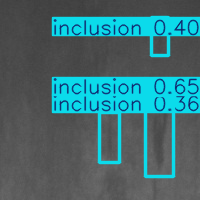

--------------------------------------------------

📷 فحص الصورة: rolled-in_scale_272.jpg

image 1/1 /content/converted_data/valid/images/rolled-in_scale_272.jpg: 224x224 1 rolled-in_scale, 21.1ms
Speed: 3.4ms preprocess, 21.1ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/runs/detect/predict


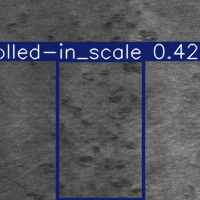

--------------------------------------------------

📷 فحص الصورة: patches_205.jpg

image 1/1 /content/converted_data/valid/images/patches_205.jpg: 224x224 4 patchess, 27.8ms
Speed: 0.8ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)
Results saved to /content/runs/detect/predict


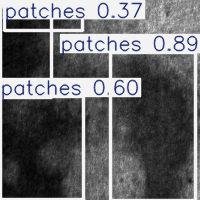

--------------------------------------------------


In [6]:
import glob
import random
from ultralytics import YOLO
import cv2
import os
from google.colab.patches import cv2_imshow

print("🕵️‍♂️ جاري اختبار الموديل على صور حقيقية...")

# 1. العثور على أفضل موديل تم تدريبه (best.pt)
# نبحث عن آخر مجلد تدريب (train, train2, train3...)
train_dirs = glob.glob('runs/detect/train*')
if train_dirs:
    latest_train_dir = max(train_dirs, key=os.path.getmtime)
    best_model_path = f'{latest_train_dir}/weights/best.pt'
    print(f"✅ تم تحميل الموديل من: {best_model_path}")

    model = YOLO(best_model_path)

    # 2. اختيار صور عشوائية للاختبار
    # نختار من مجلد 'valid' الذي أنشأناه
    test_images = glob.glob('converted_data/valid/images/*.jpg')

    if test_images:
        # نختار 3 صور عشوائية لنرى تنوع العيوب
        selected_images = random.sample(test_images, min(3, len(test_images)))

        for img_path in selected_images:
            print(f"\n📷 فحص الصورة: {os.path.basename(img_path)}")

            # 3. التوقع (Prediction)
            # conf=0.25: ثقة متوسطة
            results = model.predict(img_path, conf=0.25, save=True)

            # 4. عرض النتيجة
            # الدالة plot() ترسم المربعات والأسماء تلقائياً
            res_plotted = results[0].plot()
            cv2_imshow(res_plotted)
            print("-" * 50)
    else:
        print("⚠️ لم نجد صوراً في مجلد converted_data/valid/images")
else:
    print("❌ لم نجد ملف الموديل (best.pt). هل اكتمل التدريب؟")